# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

# load in the data take 2 by assigning dtype of column 18 and 19 to be object
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';', dtype={18:object, 19:object})
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:object, 19:object})

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [18]:
# feature description
# explore the data type for each column
def feature_description(df, report=True, return_value=True):
    '''
    Description: feature_description function returns number of categorical features and number of numerical features
    input: dataframe, optional: 1) report=True/False 2) return_value=True/False
    output: list of numerical features, list of categorical features
    '''
    features = list(df.columns)
    # drop first column as it is ID
    del features[0]
    features_number = []
    features_categorical = []
    for col in features:
        if (df[col].dtypes=='int' or df[col].dtypes=='float'):
            features_number.append(col)
        else:
            features_categorical.append(col)
    if report:
        print(pd.DataFrame([len(features_number), len(features_categorical)], 
                           index=['numerical', 'categorical'],
                           columns=['count']))
    if return_value:
        return features_number, features_categorical
    else:
        return None


azdias_number, azdias_categorical = feature_description(azdias)
print('azdias features: ', len(azdias_number), 'numerical and', len(azdias_categorical), 'categorical features.')
customers_number, customers_categorical = feature_description(customers)
print('customers features: ', len(customers_number), 'numerical and', len(customers_categorical), 'categorical features.')

             count
numerical      359
categorical      6
('azdias features: ', 359, 'numerical and', 6, 'categorical features.')
             count
numerical      360
categorical      8
('customers features: ', 360, 'numerical and', 8, 'categorical features.')


### 1. Evaluate missing data

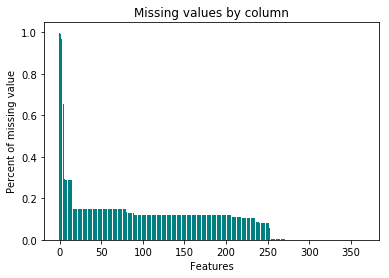

In [22]:
# missing values in Azdias data in bar plot
plt.bar(np.arange(len(azdias.columns)), azdias.isnull().sum().sort_values(ascending=False)/azdias.shape[0], color='Teal')
plt.xlabel('Features')
plt.ylabel('Percent of missing value')
plt.title('Missing values by column')
plt.show()

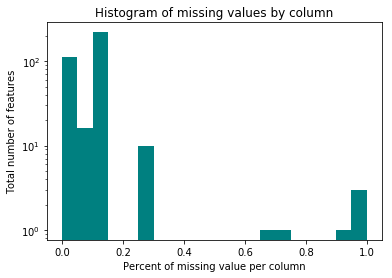

In [23]:
# histogram of missing value in azdias data
plt.hist(azdias.isnull().sum().sort_values(ascending=False)/azdias.shape[0], bins=20, color='Teal')
plt.xlabel('Percent of missing value per column')
plt.ylabel('Total number of features')
plt.title('Histogram of missing values by column')
plt.yscale('log')
plt.show()

In [4]:
customers.isnull().sum().sort_values(ascending=False).head(10) / customers.shape[0]

ALTER_KIND4     0.998769
ALTER_KIND3     0.993347
ALTER_KIND2     0.973389
ALTER_KIND1     0.938607
KK_KUNDENTYP    0.584064
EXTSEL992       0.444989
KBA05_SEG7      0.292092
KBA05_KW1       0.292092
KBA05_SEG4      0.292092
KBA05_SEG5      0.292092
dtype: float64

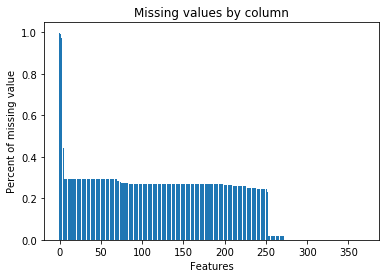

In [14]:
plt.bar(np.arange(len(customers.columns)), customers.isnull().sum().sort_values(ascending=False)/customers.shape[0])
plt.xlabel('Features')
plt.ylabel('Percent of missing value')
plt.title('Missing values by column')
plt.show()

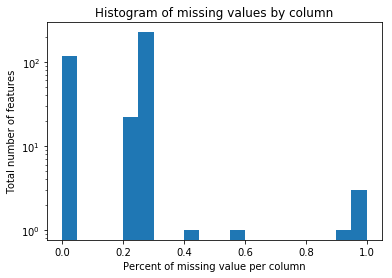

In [19]:
plt.hist(customers.isnull().sum().sort_values(ascending=False)/customers.shape[0], bins=20)
plt.xlabel('Percent of missing value per column')
plt.ylabel('Total number of features')
plt.title('Histogram of missing values by column')
plt.yscale('log')
plt.show()

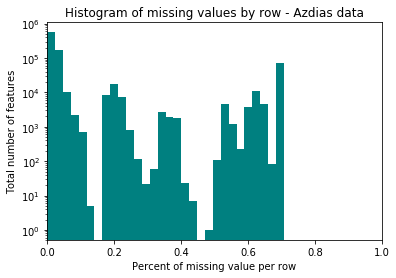

In [25]:
# missing value by rows in azdias data
plt.hist(azdias.isnull().sum(axis=1).sort_values(ascending=False)/azdias.shape[1], bins=30, color='Teal')
plt.xlabel('Percent of missing value per row')
plt.ylabel('Total number of features')
plt.title('Histogram of missing values by row - Azdias data')
plt.yscale('log')
plt.xlim([0,1])
plt.show()

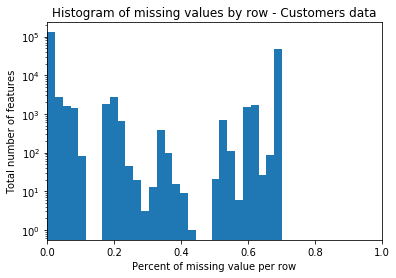

In [26]:
# missing value by rows in customers data
plt.hist(customers.isnull().sum(axis=1).sort_values(ascending=False)/customers.shape[1], bins=30)
plt.xlabel('Percent of missing value per row')
plt.ylabel('Total number of features')
plt.title('Histogram of missing values by row - Customers data')
plt.yscale('log')
plt.xlim([0,1])
plt.show()

In [5]:
customers.isnull().sum().sort_values(ascending=False).head(10) / customers.shape[0]

ALTER_KIND4     0.998769
ALTER_KIND3     0.993347
ALTER_KIND2     0.973389
ALTER_KIND1     0.938607
KK_KUNDENTYP    0.584064
EXTSEL992       0.444989
KBA05_SEG7      0.292092
KBA05_KW1       0.292092
KBA05_SEG4      0.292092
KBA05_SEG5      0.292092
dtype: float64

In [28]:
azdias.isnull().sum().sort_values(ascending=False).tail(10) / azdias.shape[0]

D19_VERSAND_REST           0.0
D19_VERSI_ANZ_12           0.0
D19_VERSI_ANZ_24           0.0
D19_VERSI_DATUM            0.0
D19_VERSI_OFFLINE_DATUM    0.0
D19_VERSI_ONLINE_DATUM     0.0
D19_VERSICHERUNGEN         0.0
D19_VOLLSORTIMENT          0.0
D19_WEIN_FEINKOST          0.0
LNR                        0.0
dtype: float64

### 2. Evaluate the extra columns in customers data

In [11]:
customers_specific_col = list(set(customers.columns) - set(azdias.columns))
print(customers_specific_col)
print(customers[customers_specific_col].head())

['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']
  CUSTOMER_GROUP      PRODUCT_GROUP  ONLINE_PURCHASE
0    MULTI_BUYER  COSMETIC_AND_FOOD                0
1   SINGLE_BUYER               FOOD                0
2    MULTI_BUYER  COSMETIC_AND_FOOD                0
3    MULTI_BUYER           COSMETIC                0
4    MULTI_BUYER               FOOD                0


In [12]:
for col in customers_specific_col:
    print(col)
    print(customers[col].unique())

CUSTOMER_GROUP
['MULTI_BUYER' 'SINGLE_BUYER']
PRODUCT_GROUP
['COSMETIC_AND_FOOD' 'FOOD' 'COSMETIC']
ONLINE_PURCHASE
[0 1]


### 3. data preprocessing

In [14]:
# take a look at categorical data 
for col in azdias_categorical:
    print(col)
    print(list(set(azdias[col].unique()).union(set(customers[col].unique())))[:5])

CAMEO_DEU_2015
[nan, '1A', '1C', '1B', '1E']
CAMEO_DEUG_2015
[nan, 'X', '1', '3', '2']
CAMEO_INTL_2015
[nan, '52', '24', '25', '22']
D19_LETZTER_KAUF_BRANCHE
[nan, 'D19_BANKEN_DIREKT', 'D19_SCHUHE', 'D19_BEKLEIDUNG_GEH', 'D19_FREIZEIT']
EINGEFUEGT_AM
[nan, '1998-01-16 00:00:00', '1997-08-08 00:00:00', '2003-09-27 00:00:00', '1996-12-17 00:00:00']
OST_WEST_KZ
[nan, 'W', 'O']


In [15]:
# it looks like EINGEFUEGT_AM contains timestamps data
# write a functionto clean categorical columns
def clean_data(df, time_series=['EINGEFUEGT_AM'],
                    categorical=['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_INTL_2015']):
    '''
    Description: clean data function 1) turns CAMEO_DEUG_2015 and CAMEO_INTL_2015 into numerical and
                                    2) turns EINGEFUEGT_AM into time series
                                    3) turns categorical data into numberical categories: -1 is nan
    Input: dataframe, list of features to turn into numerical, list of features to change to time series
            list of other categorical columns
    Output: modified df with 1) numberical results and 2) year, month, day for time series 
            and 3) categorical encodings and 4) fill na with -1
    '''
    df_new = pd.DataFrame()
    # time series
    from datetime import datetime
    for feature in time_series:
        df_new[feature+'_year'] = df[feature].apply(lambda x: -1 if str(x) == 'nan' 
                                                    else datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').year)
        df_new[feature+'_month'] = df[feature].apply(lambda x: -1 if str(x) == 'nan' 
                                                    else datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').month)
        df_new[feature+'_day'] = df[feature].apply(lambda x: -1 if str(x) == 'nan' 
                                                    else datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').day)
    # other categorical columns
    for col in categorical:
        entries = list(set(azdias[col].unique()).union(set(customers[col].unique())))
        entries.remove(np.nan)
        entries.insert(0, 'nan')
        try:
            df_new[col+'_encoded'] = df[col].apply(lambda x: entries.index(str(x))-1 )
        except:
            # new categories in dataframe compared to existing azdias and customers
            # expand the entries liest to include new categories
            new_entries = list(set(df[col].unique()) - set(entries))
            entries.extend(new_entries)
            df_new[col+'_encoded'] = df[col].apply(lambda x: entries.index(str(x))-1 )
            print('Note, the input data has new categories for column:', col)
      
    return df.drop(time_series, axis=1).drop(categorical, axis=1).drop(['LNR'],axis=1).join(df_new).fillna(-1)

In [ ]:
azdias_clean = clean_data(azdias)
customers_clean = clean_data(customers)

In [19]:
feature_description(azdias_clean, return_value=False)
feature_description(customers_clean, return_value=False)

             count
numerical      366
categorical      0
             count
numerical      367
categorical      2


In [20]:
# description of numerical columns: mean and standard deviation
features_number_description = pd.DataFrame()
for col in azdias_number:
    desc = pd.DataFrame(azdias[col].describe())
    features_number_description = pd.concat([features_number_description, desc], axis=1)

In [21]:
features_number_description

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,K

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 4. Dimensionality reduction using PCA

In [22]:
# utilize PCA to study feature importance
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_clean)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

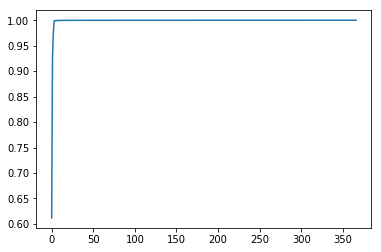

In [23]:
plt.plot(pca.explained_variance_ratio_.cumsum())

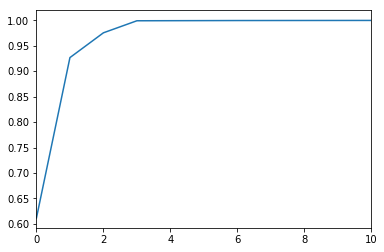

In [24]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlim([0,10])
plt.show()

In [25]:
pca.explained_variance_ratio_.cumsum()[:5]

array([0.6116653 , 0.92662455, 0.97532329, 0.99896766, 0.99918565])

In [27]:
print('top 10 important features for component 1')
pd.DataFrame(sorted(zip(azdias_clean.columns, pca.components_[0]), key=lambda x: x[1])[-10:],
            columns=['feature','coef'])

top 10 important features for component 1


,feature,coef
0,FINANZ_ANLEGER,0.000410
1,FINANZ_UNAUFFAELLIGER,0.000449
2,SEMIO_KRIT,0.000506
3,SEMIO_REL,0.000579
4,D19_VERSAND_ONLINE_DATUM,0.000871
5,D19_VERSAND_DATUM,0.000941
6,D19_GESAMT_ONLINE_DATUM,0.000966
7,D19_GESAMT_DATUM,0.001153
8,D19_KONSUMTYP_MAX,0.001159
9,KOMBIALTER,0.001284


In [39]:
print('top 10 important features for component 1 with least coef')
pd.DataFrame(sorted(zip(azdias_clean.columns, pca.components_[0]), key=lambda x: x[1])[:10],
            columns=['feature','coef'])

top 10 important features for component 1 with least coef


,feature,coef
0,GEBURTSJAHR,-0.660639
1,EINGEFUEGT_AM_year,-0.440332
2,MIN_GEBAEUDEJAHR,-0.440197
3,EINGEZOGENAM_HH_JAHR,-0.391044
4,KBA13_ANZAHL_PKW,-0.150466
5,CAMEO_DEU_2015_encoded,-0.005972
6,GEMEINDETYP,-0.005915
7,ALTERSKATEGORIE_FEIN,-0.004855
8,ALTER_HH,-0.004146
9,D19_LETZTER_KAUF_BRANCHE_encoded,-0.003603


In [28]:
print('top 10 important features for component 2')
pd.DataFrame(sorted(zip(azdias_clean.columns, pca.components_[1]), key=lambda x: x[1])[-10:],
            columns=['feature','coef'])

top 10 important features for component 2


,feature,coef
0,FINANZ_UNAUFFAELLIGER,0.000471
1,ONLINE_AFFINITAET,0.000500
2,KOMBIALTER,0.000647
3,D19_VERSAND_ONLINE_QUOTE_12,0.000701
4,D19_GESAMT_ONLINE_QUOTE_12,0.000736
5,EXTSEL992,0.000979
6,D19_LETZTER_KAUF_BRANCHE_encoded,0.001343
7,ALTER_HH,0.002131
8,ALTERSKATEGORIE_FEIN,0.004056
9,GEBURTSJAHR,0.749855


In [40]:
# select top 10 features from top5 components
selected_features = list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[0]), key=lambda x: x[1])[-10:])[0])
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[1]), key=lambda x: x[1])[-10:])[0]))
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[2]), key=lambda x: x[1])[-10:])[0]))
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[3]), key=lambda x: x[1])[-10:])[0]))
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[4]), key=lambda x: x[1])[-10:])[0]))

selected_features = list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[0]), key=lambda x: x[1])[:10])[0])
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[1]), key=lambda x: x[1])[:10])[0]))
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[2]), key=lambda x: x[1])[:10])[0]))
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[3]), key=lambda x: x[1])[:10])[0]))
selected_features.extend(list(map(None, *sorted(zip(azdias_clean.columns, pca.components_[4]), key=lambda x: x[1])[:10])[0]))


selected_features=list(set(selected_features))

In [41]:
len(selected_features)

27

In [30]:
# PCA transform both input data
azdias_pca_transform = pca.transform(azdias_clean)
customers_pca_transform = pca.transform(customers_clean[azdias_clean.columns])

In [32]:
customers['ONLINE_PURCHASE'].unique()

array([0, 1])

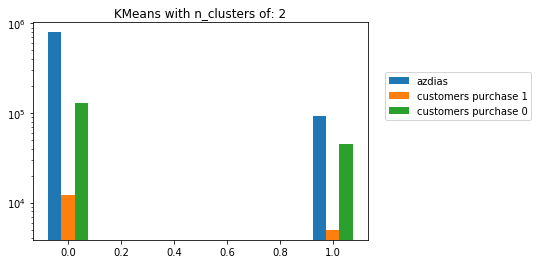

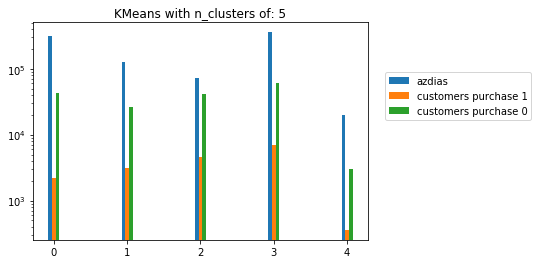

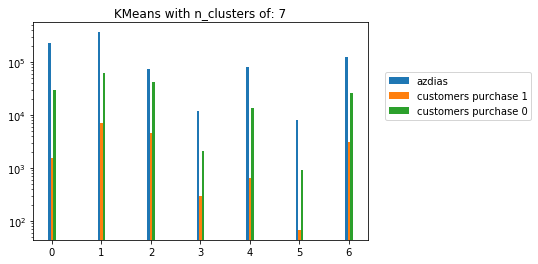

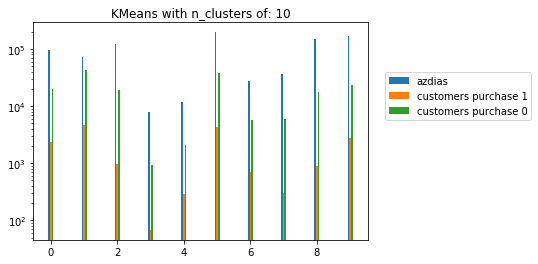

In [35]:
# using kmeans to identify any differences between customer and azdias data
from sklearn.cluster import KMeans
for i in [2, 5, 7, 10]:
    kmeans=KMeans(n_clusters= i)
    kmeans.fit(azdias_pca_transform[:,:5])
    azdias_kmeans = kmeans.predict(azdias_pca_transform[:,:5])
    #customers_kmeans = kmeans.predict(customers_pca_transform[:, :5])
    customers_purchase_kmeans = kmeans.predict(customers_pca_transform[
                                customers['ONLINE_PURCHASE']==1, :5])
    customers_no_purchase_kmeans = kmeans.predict(customers_pca_transform[
                                customers['ONLINE_PURCHASE']==0, :5])
    unique, counts = np.unique(azdias_kmeans, return_counts=True)
    unique_customer, counts_customer = np.unique(customers_purchase_kmeans, return_counts=True)
    unique_no_purchase, counts_no_purchase = np.unique(customers_no_purchase_kmeans, return_counts=True)
    plt.figure()
    plt.bar(unique-0.05, counts, width=0.05, label='azdias')
    plt.bar(unique_customer, counts_customer, width=0.05, label='customers purchase 1')
    plt.bar(unique_no_purchase+0.05, counts_no_purchase, width=0.05, label='customers purchase 0')
    plt.legend(loc=(1.05,0.55))
    plt.yscale('log')
    plt.title('KMeans with n_clusters of: '+str(i))
    plt.show()
 

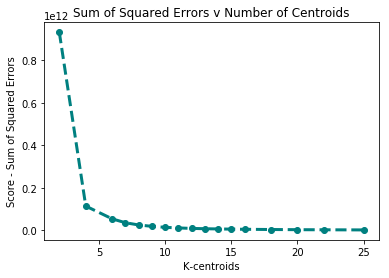

In [49]:
# Function to calculate K-Means score for a centroid
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

# Run possible number of cluster centroid through K-means score function
score_pca = []
centroids = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]

for x in centroids:
    score_pca.append(get_kmeans_score(azdias_pca_transform[:,:5],x))
    
# print score report
pd.DataFrame(sorted(zip(centroids, score_pca), key=lambda x: x[1]),
            columns=['centroids','score'])

plt.plot(centroids,score_pca,linestyle='--',linewidth=3,marker='o',color='teal')
plt.xlabel('K-centroids')
plt.ylabel('Score - Sum of Squared Errors')
plt.title('Sum of Squared Errors v Number of Centroids');

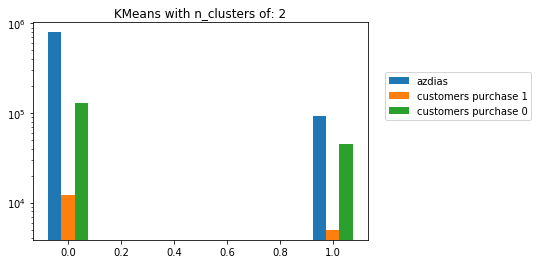

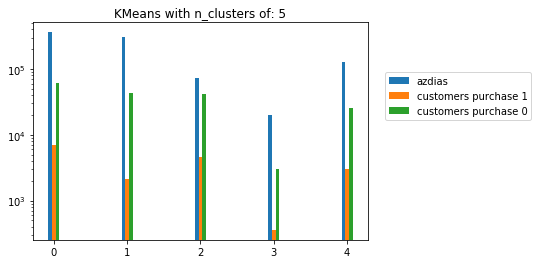

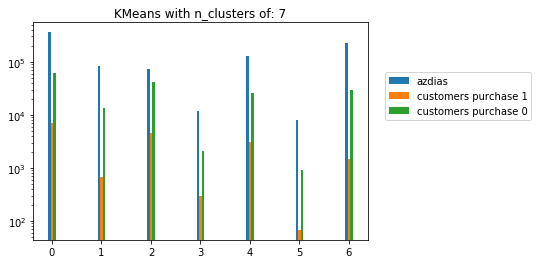

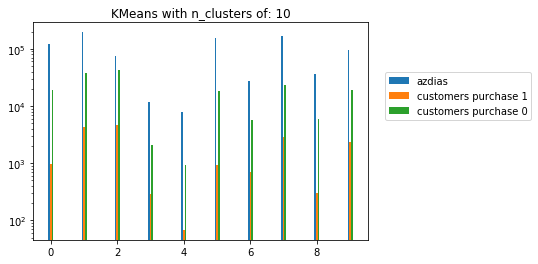

In [42]:
# use top selected features for kmeans clustering analysis
from sklearn.cluster import KMeans
for i in [2, 5, 7, 10]:
    kmeans=KMeans(n_clusters= i)
    kmeans.fit(azdias_clean[selected_features])
    azdias_kmeans = kmeans.predict(azdias_clean[selected_features])
    #customers_kmeans = kmeans.predict(customers_pca_transform[:, :5])
    customers_purchase_kmeans = kmeans.predict(customers_clean.loc[
                                customers['ONLINE_PURCHASE']==1, selected_features])
    customers_no_purchase_kmeans = kmeans.predict(customers_clean.loc[
                                customers['ONLINE_PURCHASE']==0, selected_features])
    unique, counts = np.unique(azdias_kmeans, return_counts=True)
    unique_customer, counts_customer = np.unique(customers_purchase_kmeans, return_counts=True)
    unique_no_purchase, counts_no_purchase = np.unique(customers_no_purchase_kmeans, return_counts=True)
    plt.figure()
    plt.bar(unique-0.05, counts, width=0.05, label='azdias')
    plt.bar(unique_customer, counts_customer, width=0.05, label='customers purchase 1')
    plt.bar(unique_no_purchase+0.05, counts_no_purchase, width=0.05, label='customers purchase 0')
    plt.legend(loc=(1.05,0.55))
    plt.yscale('log')
    plt.title('KMeans with n_clusters of: '+str(i))
    plt.show()

In [45]:
# Run possible number of cluster centroid through K-means score function
score = []
centroids = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]

for x in centroids:
    score_temp=get_kmeans_score(azdias_clean[selected_features],x)
    score.append(score_temp)
    print(x, score_temp)


(2, 933685972416.2578)
(4, 115396169562.67476)
(6, 55245705636.72534)
(7, 36957059775.88173)
(8, 26508723043.4412)
(9, 20018821982.748936)
(10, 15384467584.110973)
(11, 12487549506.881035)
(12, 10294299979.963871)
(13, 8890173201.062225)
(14, 7778358529.962918)
(15, 6973970750.646559)
(16, 6180643300.845229)
(18, 5120695602.400734)
(20, 4303088080.004126)
(22, 3831121764.720846)
(25, 3221129109.8365545)


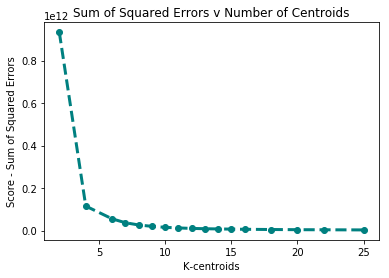

In [46]:
# Investigate the change in within-cluster distance across number of clusters.
#fig = plt.subplots(figsize=(16,10))
plt.plot(centroids,score,linestyle='--',linewidth=3,marker='o',color='teal')
plt.xlabel('K-centroids')
plt.ylabel('Score - Sum of Squared Errors')
plt.title('Sum of Squared Errors v Number of Centroids');

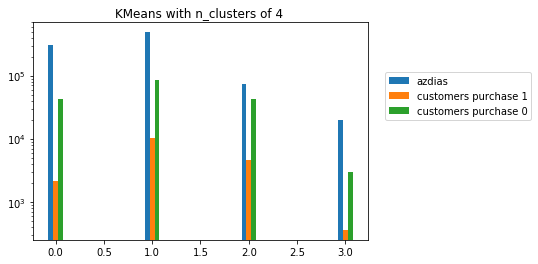

In [48]:
kmeans_4 = KMeans(n_clusters= 4)
kmeans_4.fit(azdias_clean[selected_features])
azdias_kmeans = kmeans_4.predict(azdias_clean[selected_features])
customers_purchase_kmeans = kmeans_4.predict(customers_clean.loc[
                                customers['ONLINE_PURCHASE']==1, selected_features])
customers_no_purchase_kmeans = kmeans_4.predict(customers_clean.loc[
                                customers['ONLINE_PURCHASE']==0, selected_features])
unique, counts = np.unique(azdias_kmeans, return_counts=True)
unique_customer, counts_customer = np.unique(customers_purchase_kmeans, return_counts=True)
unique_no_purchase, counts_no_purchase = np.unique(customers_no_purchase_kmeans, return_counts=True)
plt.figure()
plt.bar(unique-0.05, counts, width=0.05, label='azdias')
plt.bar(unique_customer, counts_customer, width=0.05, label='customers purchase 1')
plt.bar(unique_no_purchase+0.05, counts_no_purchase, width=0.05, label='customers purchase 0')
plt.legend(loc=(1.05,0.55))
plt.yscale('log')
plt.title('KMeans with n_clusters of 4 ')
plt.show()
 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [50]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:object, 19:object})
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:object, 19:object})

In [51]:
y_train = mailout_train['RESPONSE']    
X_train = clean_data(mailout_train.drop(['RESPONSE'], axis=1))
X_train_pca = pca.transform(X_train)

In [52]:
from sklearn.model_selection import train_test_split

train_X_train, train_X_test, train_y_train, train_y_test = train_test_split(X_train, y_train, stratify= y_train, test_size=0.3)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(X_train_pca, y_train, stratify= y_train, test_size=0.3)


In [54]:
# compare pca data to selected feature data
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(train_X_train, train_y_train)
print('=====================================')
print(gbc)
print('Result for selected feature input   ')
print('y_train', np.unique(train_y_train, return_counts=True))
print('y_train_predict', np.unique(gbc.predict(train_X_train), return_counts=True))
print('y_test ', np.unique(train_y_test, return_counts=True))
print('y_test_predict ', np.unique(gbc.predict(train_X_test), return_counts=True))

gbc_pca = GradientBoostingClassifier()
gbc_pca.fit(pca_X_train[:,:5], pca_y_train)
print('=====================================')
print(gbc_pca)
print('Result for pca transformed input (5 components)   ')
print('y_train', np.unique(pca_y_train, return_counts=True))
print('y_train_predict', np.unique(gbc_pca.predict(pca_X_train[:,:5]), return_counts=True))
print('y_test ', np.unique(pca_y_test, return_counts=True))
print('y_test_predict ', np.unique(gbc_pca.predict(pca_X_test[:,:5]), return_counts=True))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Result for selected feature input   
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([30049,    24])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12882,     7])))
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_sam

In [56]:
# input data after pca transformation has higher true positive in test data set
# fine tuning for gbc using pca transformed data

param_test1 = {'n_estimators':[100, 200], 'subsample':[0.8,1.0], 'min_samples_split':[2,4,8], 'max_depth':[3,6,9], 'learning_rate':[0.01,0.1, 1]}

# find the best max_depth
for n in [2,4,6,8,10,12]:
    gbc = GradientBoostingClassifier(max_depth=n )
    gbc.fit(pca_X_train[:,:5], pca_y_train)
    print('=====================================')
    print('max_depth', ' : ', n, '  result   ')
    print('y_train', np.unique(pca_y_train, return_counts=True))
    print('y_train_predict', np.unique(gbc.predict(pca_X_train[:,:5]), return_counts=True))
    print('y_test ', np.unique(pca_y_test, return_counts=True))
    print('y_test_predict ', np.unique(gbc.predict(pca_X_test[:,:5]), return_counts=True))

('max_depth', ' : ', 2, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29996,    77])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12851,    38])))
('max_depth', ' : ', 4, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29800,   273])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12756,   133])))
('max_depth', ' : ', 6, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29756,   317])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12768,   121])))
('max_depth', ' : ', 8, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29744,   329])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test

In [57]:
# find the best learning_rate
for n in [0.01, 0.1, 0.5, 0.9]:
    gbc = GradientBoostingClassifier(max_depth=4, learning_rate=n )
    gbc.fit(pca_X_train[:,:5], pca_y_train)
    print('=====================================')
    print('learning_rate', ' : ', n, '  result   ')
    print('y_train', np.unique(pca_y_train, return_counts=True))
    print('y_train_predict', np.unique(gbc.predict(pca_X_train[:,:5]), return_counts=True))
    print('y_test ', np.unique(pca_y_test, return_counts=True))
    print('y_test_predict ', np.unique(gbc.predict(pca_X_test[:,:5]), return_counts=True))

('learning_rate', ' : ', 0.01, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([30070,     3])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12888,     1])))
('learning_rate', ' : ', 0.1, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29800,   273])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12759,   130])))
('learning_rate', ' : ', 0.5, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29768,   305])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12767,   122])))
('learning_rate', ' : ', 0.9, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29829,   244])))
('y_test ', (array([0, 1]), array([

In [59]:
# find the best n_estimator
for n in [50, 100, 150, 200, 250, 300]:
    gbc = GradientBoostingClassifier(max_depth=4, learning_rate=0.1, n_estimators=n )
    gbc.fit(pca_X_train[:,:5], pca_y_train)
    print('=====================================')
    print('n_estimator', ' : ', n, '  result   ')
    print('y_train', np.unique(pca_y_train, return_counts=True))
    print('y_train_predict', np.unique(gbc.predict(pca_X_train[:,:5]), return_counts=True))
    print('y_test ', np.unique(pca_y_test, return_counts=True))
    print('y_test_predict ', np.unique(gbc.predict(pca_X_test[:,:5]), return_counts=True))

('n_estimator', ' : ', 50, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29925,   148])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12812,    77])))
('n_estimator', ' : ', 100, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29800,   273])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12758,   131])))
('n_estimator', ' : ', 150, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29761,   312])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12749,   140])))
('n_estimator', ' : ', 200, '  result   ')
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29754,   319])))
('y_test ', (array([0, 1]), array([12729,   1

### Tuned parameters

In [60]:
gbc = GradientBoostingClassifier(max_depth=4, learning_rate=0.1, n_estimators=150 )
gbc.fit(pca_X_train[:,:5], pca_y_train)
print('=====================================')
print('input data: pca transformed clean_data with 5 components result   ')
print('y_train', np.unique(pca_y_train, return_counts=True))
print('y_train_predict', np.unique(gbc.predict(pca_X_train[:,:5]), return_counts=True))
print('y_test ', np.unique(pca_y_test, return_counts=True))
print('y_test_predict ', np.unique(gbc.predict(pca_X_test[:,:5]), return_counts=True))

input data: pca transformed clean_data with 5 components result   
('y_train', (array([0, 1]), array([29701,   372])))
('y_train_predict', (array([0, 1]), array([29761,   312])))
('y_test ', (array([0, 1]), array([12729,   160])))
('y_test_predict ', (array([0, 1]), array([12752,   137])))


In [61]:
gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [64]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:object, 19:object})

In [65]:
mailout_test_predict = gbc.predict_proba(pca.transform(clean_data(mailout_test))[:,:5])

In [87]:
mailout_test['RESPONSE'] = mailout_test_predict[:,1]
mailout_test[['LNR','RESPONSE']].to_csv('submission_0301_4.csv', index=False)

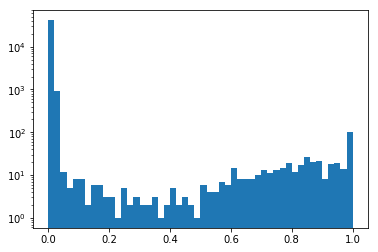

In [88]:
plt.hist(mailout_test_predict[:,1],bins=50)
plt.yscale('log')
plt.show()

In [ ]:
The report was publised on:
    https://medium.com/@huoww07/segmentation-report-for-arvato-financial-services-bb4b18e9b8b0
        